# Introduction to Machine Learning — 2023/2024 Reinforcement Learning



### Exercise 1

Build the simulation environment. Develop the following functionalities:

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd

a) The state-transition function (s′ = f (s, a)), where a state (s) and an action (a) are given as argument, and a new state (the arrival state, s′) is returned, so that: f(1,right) = 2, f(1, down) = 11, f(1, up) = 1, etc.

In [13]:
def stateTransitionFunction(state, action):
    newstate = state
    if newstate == 100:
        newstate = 1
    elif action == 'right':
        newstate += 1
    elif action == 'left':
        newstate -= 1
    elif action == 'up':
        newstate -= 10
    elif action == 'down':
        newstate += 10
    
    if state == 100:
        state = newstate
    elif newstate in range(1, 101):
        if not (state % 10 == 1 and action == 'left') and not (state % 10 == 0 and action == 'right'):
            state = newstate

    return state

b) A reward function r(s) that rewards all states with 0 and the goal-state (state 100) with 100 points.

In [14]:
def getReward(state):
    reward = 0
    if state == 100:
        reward = 100
    else:
        pass

    return (reward)

c) A function that randomly chooses an action.

In [15]:
def randomlyChoseAction():
    possibleActions = ["up", "left", "right", "down"]
    randomPosition = random.randint(0,3)
    randomAction = possibleActions[randomPosition]

    return (randomAction)


d)  An episode consists in all the movements from the start-point until it reaches the goal, or until it gives-up (because it has reached the maximum number of steps allowed). Define the end of the episode as: the robot reaches the goal-state (the plug, marked with an X, state 100) or the robot performs 1000 actions without reaching the goal. After the end of an episode the robot gets the reward (if it has reached the goal) and is always returned to the initial position. 

In [16]:
def runEpisode(state = 1, finalState = 100, maxNumberStepsAllowed = 1000):
    numberOfStepsEpisode = 0
    reward = 0

    while state != finalState and numberOfStepsEpisode < maxNumberStepsAllowed:
        state = stateTransitionFunction(state, randomlyChoseAction())
        reward += getReward(state) 
        numberOfStepsEpisode +=1

    return (numberOfStepsEpisode, reward)

e) Simulate the robot performing an episode and repeat it 30 times. 

Measure and record the average reward per step in each episode and the number of steps to reach the goal in each episode. 

Calculate the mean and standard deviation of the number of steps to reach the goal, execution times, and rewards for the 30 tests. 

These will be the reference results and will be used to test whether the system is performing better than just guessing randomly.


In [32]:
def testBaseline(baseline = False, visualize = True):

    allNumberOfStepsEpisode = []
    allRewards = [] # need???
    allexecutionTimes = []
    allRewardsPerSteps = []

    random.seed(1300)
    for i in range(30):
        startTime = time.time()
        if baseline == True:
            numberOfStepsEpisode, reward = runEpisode()
        else: 
            numberOfStepsEpisode, reward = runEpisode()
            
        endTime = time.time()
        executionTime = endTime - startTime

        allNumberOfStepsEpisode.append(numberOfStepsEpisode)
        allRewards.append(reward)
        allexecutionTimes.append(executionTime)

        rewardPerStep = reward/numberOfStepsEpisode
        allRewardsPerSteps.append(rewardPerStep)


    # get metrics

    # steps needed
    meanNumberOfStepsEpisode = sum(allNumberOfStepsEpisode) /len(allNumberOfStepsEpisode)
    sdNumberOfStepsEpisode = np.std(allNumberOfStepsEpisode)
    print(f"number of steps mean: {meanNumberOfStepsEpisode}, sd: {sdNumberOfStepsEpisode}")

    # reward total
    meanRewards = sum(allRewards) /len(allRewards)
    sdRewards = np.std(allRewards)
    print(f"overall reward mean: {meanRewards}, sd: {sdRewards}")

    # execution time
    meanExecutionTimesExploration = sum(allexecutionTimes) /len(allexecutionTimes)
    sdExecutionTimes = np.std(allexecutionTimes)
    print(f"execution time mean: {meanExecutionTimesExploration}, sd: {sdExecutionTimes}")

    # average reward per step
    averageRewardPerStep = sum(allRewardsPerSteps) /len(allRewardsPerSteps)
    sdRewardPerStep = np.std(allRewardsPerSteps)
    print(f"average rewards per step: {averageRewardPerStep}, sd: {sdRewardPerStep}")

    if visualize == True:
        # visualize metrics
        fig, axs = plt.subplots(1, 3)

        axs[0].boxplot(allRewardsPerSteps, 
                        patch_artist=True)
        axs[0].set_title("mean reward per step")
        axs[0].set_xticks([])

        axs[1].boxplot(allNumberOfStepsEpisode, 
                        patch_artist=True)
        axs[1].set_title("mean number of steps")
        axs[1].set_xticks([])

        axs[2].boxplot(allexecutionTimes, 
                        patch_artist=True)
        axs[2].set_title("mean execution time (s)")
        axs[2].set_xticks([])

        fig.subplots_adjust(left=0.2, right=1.4, bottom=0.05, top=0.9,
                            hspace=0.4, wspace=0.3)


        plt.show()





f) Represent the mean and standard deviation (reward, steps to reach the goal, and execution times), each in a different boxplot with vertical boxes.

number of steps mean: 486.7, sd: 264.479129611393
overall reward mean: 90.0, sd: 30.0
execution time mean: 0.0007136583328247071, sd: 0.0004069764042177267
average rewards per step: 0.29309509947675466, sd: 0.23733557811951853


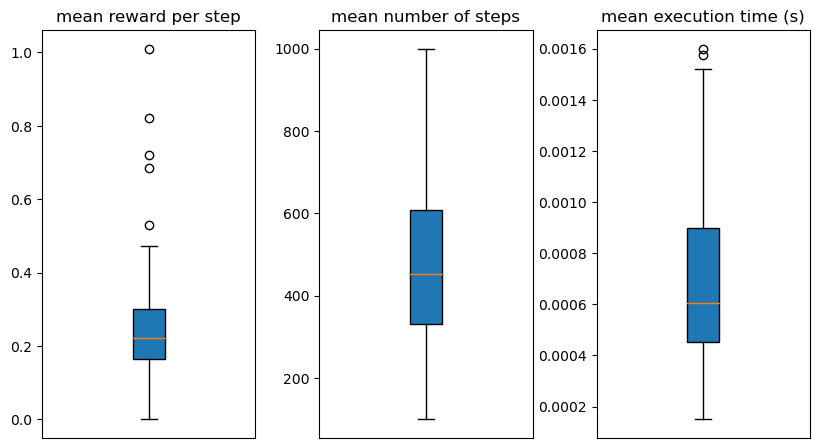

In [33]:
testBaseline(baseline = False)

# Exercise 2

Create a matrix Q

In [19]:
dType = [('right', 'f4'), ('left', 'f4'), ('up', 'f4'), ('down', 'f4')]
matrixQEmpty = np.zeros(101, dtype = dType)

In [20]:
def getUpdatedUtility(state, action, matrixQ, alpha, discountRate):
    QAtStateAndAction = matrixQ[action][state]
    nextState = stateTransitionFunction(state, action)
    rewardAtNextState = getReward(nextState)

    allPossibleUtilitiesAtNextState = [matrixQ["right"][nextState], matrixQ["left"][nextState], matrixQ["up"][nextState], matrixQ["down"][nextState]]
    random.shuffle(allPossibleUtilitiesAtNextState) # for ties, because max gives first value when tie
    maxUtilityNextState = max(allPossibleUtilitiesAtNextState)

    utilityState = (1-alpha)*QAtStateAndAction + alpha * (rewardAtNextState + discountRate*maxUtilityNextState)
    return (utilityState)

def updateUtility(state, action, matrixQ, alpha = 0.7, discountRate = 0.99):
    updatedUtility = getUpdatedUtility(state, action, matrixQ, alpha, discountRate)
    matrixQ[action][state] = updatedUtility

    return (matrixQ)


a) Do a random walk (like in Exercise 1) and execute this update-function after each state transition for 20000 steps in each experiment. Repeat the experiment 30 times. In each of the 30 experiments, at steps 100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, and 20000 (or other intermediate points that are deemed useful) stop to run a test.

A test consists of running the system for 1000 steps using the current Q table (without changing it) and always choosing the best action at each step. Measure the average reward per step in these 1000 steps.

Measure also the runtime of each full test (all 20000 steps) and calculate average and standard-deviation of run-times for the tests. 

Plot the steps (x-axis) vs the average reward (y-axis) of the tests at the measured points. A series of box plots can also be used for a more informative view of the evolution of the robot’s behaviour.

Depict the final utility of each state (the quality of the best action for each state), rep- resenting what the agent learned about the environment, using a heatmap (Figure 3).


In [50]:
def getNextBestStep(state, matrixQ):
    allPossibleUtilitiesAtThisState = {"right": matrixQ["right"][state], 
                                       "left": matrixQ["left"][state], 
                                       "up": matrixQ["up"][state], 
                                       "down": matrixQ["down"][state]}
    dictInShuffleProcess = list(allPossibleUtilitiesAtThisState.items())
    random.shuffle(dictInShuffleProcess)
    allPossibleUtilitiesAtThisState = dict(dictInShuffleProcess)
    maxUtilityNextState = max(allPossibleUtilitiesAtThisState, key = allPossibleUtilitiesAtThisState.get)
    return (maxUtilityNextState)

def runTest(state, matrixQ, howManySteps = 1000):
    rewardOverall = 0
    for i in range(howManySteps):
        action = getNextBestStep(state, matrixQ)
        state = stateTransitionFunction(state, action)
        rewardOverall += getReward(state)
    averageRewardPerStep = rewardOverall/howManySteps
    return (averageRewardPerStep)
    
def runEpisodeWithUpdatingUtilities(matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000, alwaysBestStep = False):
    copyMatrixQ = matrixQ.copy()
    listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
    count = 0
    allAverageRewardsPerStep = []

    for i in range(maxNumberSteps+1):

        if alwaysBestStep == True:
            action = getNextBestStep(state, copyMatrixQ)
        else:
            action = randomlyChoseAction()

        newState = stateTransitionFunction(state, action)
        copyMatrixQ = updateUtility(state = state, action = action, matrixQ = copyMatrixQ)
        state = newState

        if count in listWithPointsWhereTorRunTests:
            allAverageRewardsPerStep.append(runTest(state = state, matrixQ = copyMatrixQ, howManySteps = 1000))
        
        count += 1
        
    return (allAverageRewardsPerStep, copyMatrixQ)

def getAveragedMatrixQ(allMatrixQInList):
    # get correct format of arrays
    allArraysCorrectFormat = [np.stack([matrixQ['right'], matrixQ['left'], matrixQ['up'], matrixQ['down']], axis=-1) 
             for matrixQ in allMatrixQInList]
    # put arrays in 3-dim array and take mean over 3rd dimension
    allMatrixQInArray = np.stack(allArraysCorrectFormat, axis = 2)
    allMatrixQInArrayAverage = np.mean(allMatrixQInArray, axis = 2)

     # Create a new structured array to store the averaged values
    finalAllMatrixQInArrayAverage = np.zeros(101, dtype=dType)

    # Populate the new structured array with averaged values
    finalAllMatrixQInArrayAverage['right'] = allMatrixQInArrayAverage[:, 0]
    finalAllMatrixQInArrayAverage['left'] = allMatrixQInArrayAverage[:, 1]
    finalAllMatrixQInArrayAverage['up'] = allMatrixQInArrayAverage[:, 2]
    finalAllMatrixQInArrayAverage['down'] = allMatrixQInArrayAverage[:, 3]

    return (finalAllMatrixQInArrayAverage)    

def showHeatmap(matrixQ):

    directions = ['right', 'left', 'up', 'down']

    arrayForHeatMap = np.zeros(101)
    directionsWithHighestUtility = np.zeros(101, dtype=int)
    for count, row in enumerate(matrixQ):
        utilities = np.array([row['right'], row['left'], row['up'], row['down']])
        maxIndex = np.argmax(utilities)
        arrayForHeatMap[count] = utilities[maxIndex]
        directionsWithHighestUtility[count] = maxIndex
    arrayForHeatMap = np.delete(arrayForHeatMap, obj=0)

    arrayForHeatMap = arrayForHeatMap.reshape((10, 10))

    fig, ax = plt.subplots(figsize=(8, 8))
    heatmap = ax.imshow(arrayForHeatMap, cmap='hot')
    fig.colorbar(heatmap)

    arrowOffset = 0.3

    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            direction = directions[directionsWithHighestUtility[index]]
            
            # Coordinates for placing arrows in each cell
            x = j
            y = i

            # Draw arrows based on the highest direction
            if direction == 'right':
                ax.arrow(x, y, arrowOffset, 0, head_width=0.05, head_length=0.1, fc='green', ec='green')
            elif direction == 'left':
                ax.arrow(x, y, -arrowOffset, 0, head_width=0.05, head_length=0.1, fc='green', ec='green')
            elif direction == 'up':
                ax.arrow(x, y, 0, -arrowOffset, head_width=0.05, head_length=0.1, fc='green', ec='green')
            elif direction == 'down':
                ax.arrow(x, y, 0, arrowOffset, head_width=0.05, head_length=0.1, fc='green', ec='green')

    plt.title('Heatmap of Highest Utility Directions')
    plt.show()


In [48]:
def runTestEpisode(matrixQ, state = 1, finalState = 100, maxNumberStepsAllowed = 1000):
    numberOfStepsEpisode = 0
    reward = 0

    while state != finalState and numberOfStepsEpisode < maxNumberStepsAllowed:
        state = stateTransitionFunction(state, getNextBestStep(state, matrixQ))
        reward += getReward(state) 
        numberOfStepsEpisode +=1

    return (numberOfStepsEpisode, reward)

def testBaseline(matrixQ, baseline = False, visualize = True):

    allNumberOfStepsEpisode = []
    allRewards = [] # need???
    allexecutionTimes = []
    allRewardsPerSteps = []

    random.seed(1300)
    for i in range(30):
        startTime = time.time()
        if baseline == True:
            numberOfStepsEpisode, reward = runEpisode()
        else: 
            numberOfStepsEpisode, reward = runTestEpisode(matrixQ)
            
        endTime = time.time()
        executionTime = endTime - startTime

        allNumberOfStepsEpisode.append(numberOfStepsEpisode)
        allRewards.append(reward)
        allexecutionTimes.append(executionTime)

        rewardPerStep = reward/numberOfStepsEpisode
        allRewardsPerSteps.append(rewardPerStep)


    # get metrics

    # steps needed
    meanNumberOfStepsEpisode = sum(allNumberOfStepsEpisode) /len(allNumberOfStepsEpisode)
    sdNumberOfStepsEpisode = np.std(allNumberOfStepsEpisode)
    print(f"number of steps mean: {meanNumberOfStepsEpisode}, sd: {sdNumberOfStepsEpisode}")

    # reward total
    meanRewards = sum(allRewards) /len(allRewards)
    sdRewards = np.std(allRewards)
    print(f"overall reward mean: {meanRewards}, sd: {sdRewards}")

    # execution time
    meanExecutionTimesExploration = sum(allexecutionTimes) /len(allexecutionTimes)
    sdExecutionTimes = np.std(allexecutionTimes)
    print(f"execution time mean: {meanExecutionTimesExploration}, sd: {sdExecutionTimes}")

    # average reward per step
    averageRewardPerStep = sum(allRewardsPerSteps) /len(allRewardsPerSteps)
    sdRewardPerStep = np.std(allRewardsPerSteps)
    print(f"average rewards per step: {averageRewardPerStep}, sd: {sdRewardPerStep}")

    if visualize == True:
        # visualize metrics
        fig, axs = plt.subplots(1, 3)

        axs[0].boxplot(allRewardsPerSteps, 
                        patch_artist=True)
        axs[0].set_title("mean reward per step")
        axs[0].set_xticks([])

        axs[1].boxplot(allNumberOfStepsEpisode, 
                        patch_artist=True)
        axs[1].set_title("mean number of steps")
        axs[1].set_xticks([])

        axs[2].boxplot(allexecutionTimes, 
                        patch_artist=True)
        axs[2].set_title("mean execution time (s)")
        axs[2].set_xticks([])

        fig.subplots_adjust(left=0.2, right=1.4, bottom=0.05, top=0.9,
                            hspace=0.4, wspace=0.3)


        plt.show()


execution time mean: 0.5063555796941122, sd: 0.06034024590611463
number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00011541843414306641, sd: 0.00010135168562978756
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


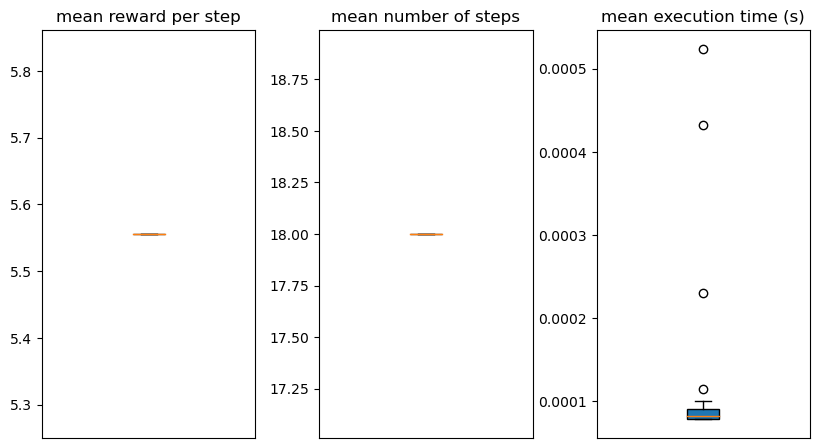

In [ ]:
allexecutionTimes = []
allAllAverageRewardsPerStep = np.zeros((30, 16))
allMatrixQInList = []

random.seed(170)
for i in range(30):
    startTime = time.time()
    allAverageRewardsPerStep, MatrixQEndExploration = runEpisodeWithUpdatingUtilities()
    endTime = time.time()
    executionTime = endTime - startTime

    allAllAverageRewardsPerStep[i] = allAverageRewardsPerStep

    
    allexecutionTimes.append(executionTime)
    allMatrixQInList.append(MatrixQEndExploration)



# execution time
meanExecutionTimesExploration = sum(allexecutionTimes) /len(allexecutionTimes)
sdExecutionTimes = np.std(allexecutionTimes)
#print(f"execution time mean: {meanExecutionTimesExploration}, sd: {sdExecutionTimes}")


# average rewards per step for the 16 steps
averageRewardMeansRandom = np.mean(allAllAverageRewardsPerStep, axis=0)

# average utilities in matrices
averageMatrixQExploration = getAveragedMatrixQ(allMatrixQInList)


# compare with baseline
testBaseline(averageMatrixQExploration, baseline = False, visualize = True)

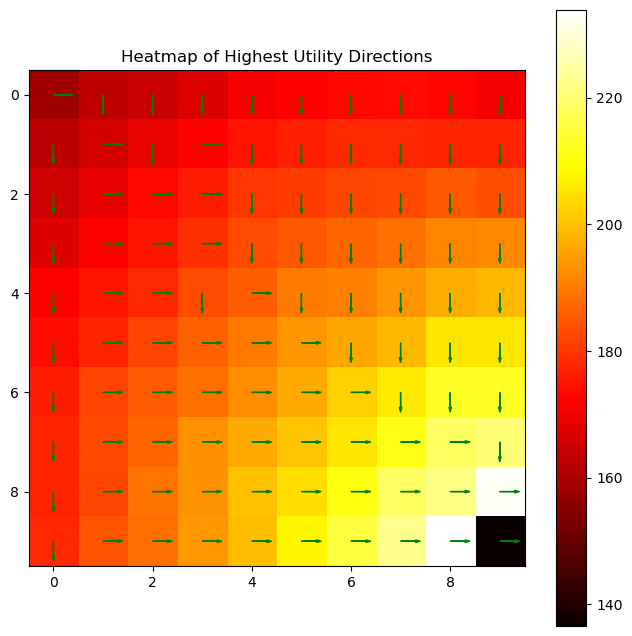

In [53]:
showHeatmap(averageMatrixQExploration)

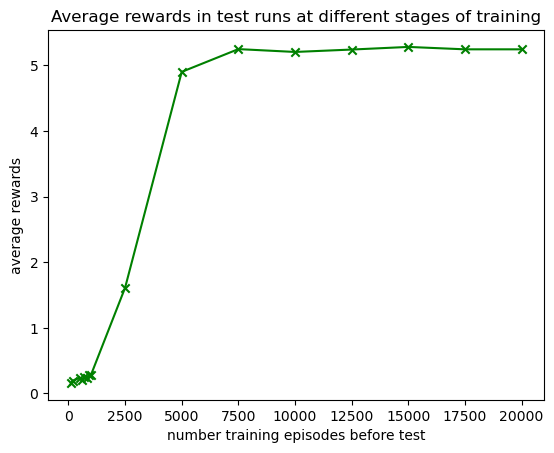

In [54]:
# visualize average reward 
listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c="green", label = "random steps")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c='green', marker='x')
plt.title('Average rewards in test runs at different stages of training')
plt.xlabel("number training episodes before test")
plt.ylabel("average rewards")
plt.show()

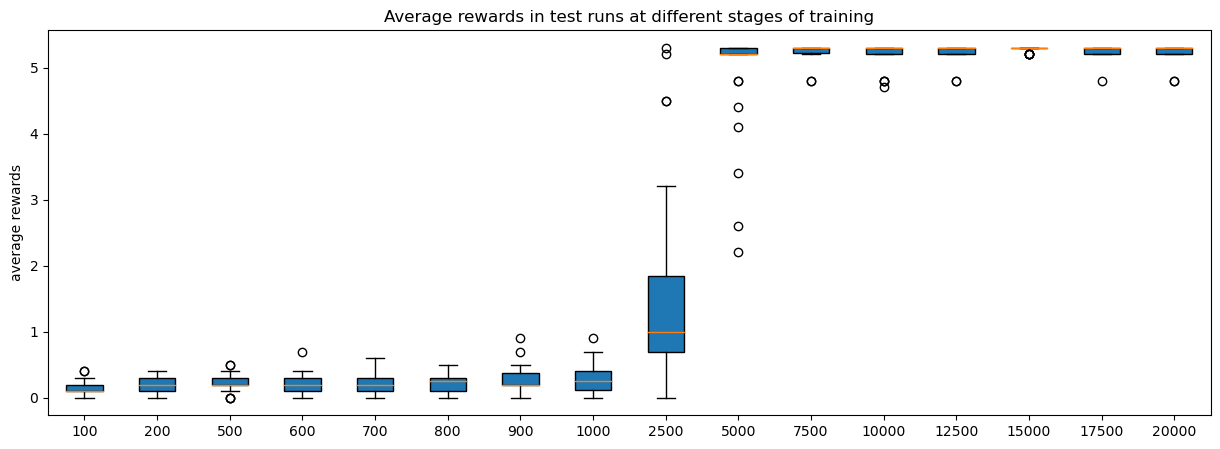

In [55]:
# show average rewards in boxplots
def showBoxplot(values, labels):

    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_ylabel("average rewards")
    ax.set_title('Average rewards in test runs at different stages of training')
    bplot = ax.boxplot(values, 
                    labels = labels, 
                    patch_artist=True,
                    whis=1.5)
    plt.show()

showBoxplot(values = allAllAverageRewardsPerStep, labels = listWithPointsWhereTorRunTests)

b) Do the same test as the previous example, but instead of a random walk use always the Q-table values to choose the best action. Be careful to break ties randomly.

execution time mean: 0.617228094736735, sd: 0.06533151757261008
number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00012052059173583984, sd: 5.622510491058119e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


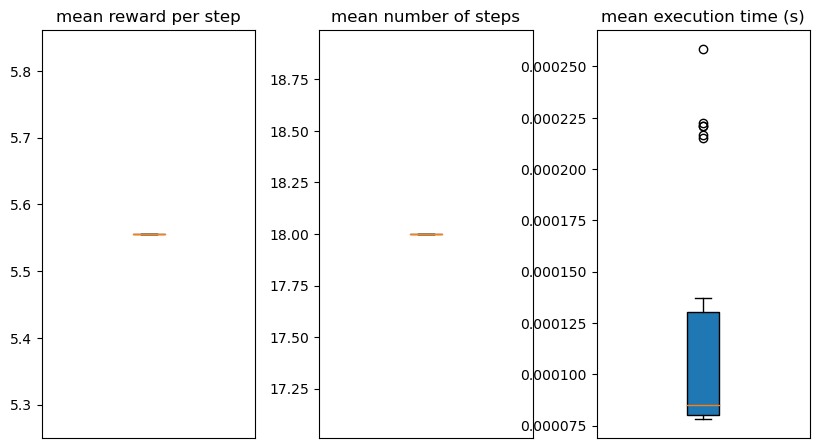

In [56]:
allexecutionTimesExploitation = []
allAllAverageRewardsPerStepExploitation = np.zeros((30, 16))
allMatrixQInList = []

random.seed(10)
for i in range(30):
    startTime = time.time()
    allAverageRewardsPerStep, copyMatrixQExploitation = runEpisodeWithUpdatingUtilities(alwaysBestStep = True)
    endTime = time.time()
    executionTime = endTime - startTime
    allAllAverageRewardsPerStepExploitation[i] = allAverageRewardsPerStep
    allMatrixQInList.append(copyMatrixQExploitation)

    
    allexecutionTimesExploitation.append(executionTime)



# execution time
meanExecutionTimesExploitation = sum(allexecutionTimesExploitation) /len(allexecutionTimesExploitation)
sdExecutionTimesExploitation = np.std(allexecutionTimesExploitation)
print(f"execution time mean: {meanExecutionTimesExploitation}, sd: {sdExecutionTimesExploitation}")


# average rewards per step for the 16 steps
averageRewardMeansAlwaysBest = np.mean(allAllAverageRewardsPerStepExploitation, axis=0)


# average utilities in matrices
averageMatrixQExploitation = getAveragedMatrixQ(allMatrixQInList)


# compare with baseline
testBaseline(averageMatrixQExploitation, baseline = False, visualize = True)

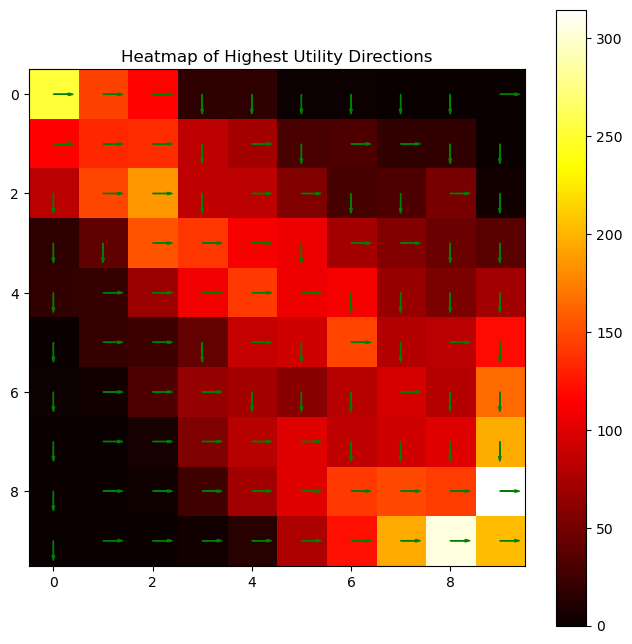

In [57]:
showHeatmap(averageMatrixQExploitation)

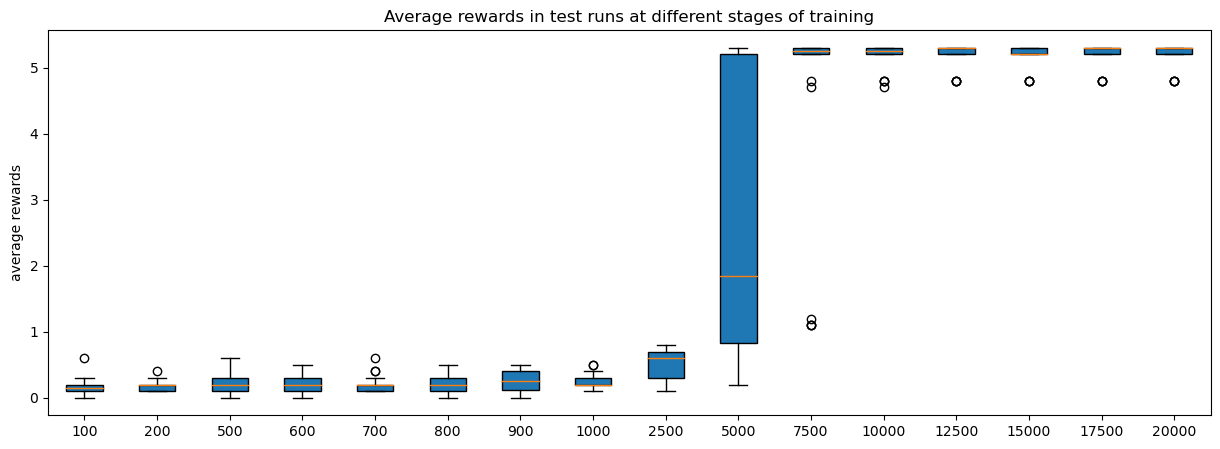

In [58]:
showBoxplot(values = allAllAverageRewardsPerStepExploitation, labels = listWithPointsWhereTorRunTests)

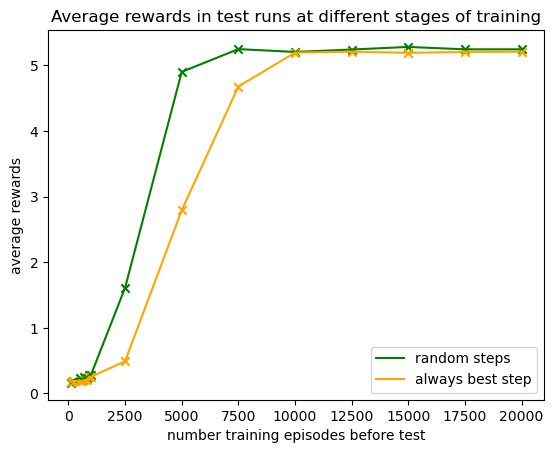

In [59]:
# visualize average reward 
listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c="green", label = "random steps")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansRandom,c='green', marker='x')

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", label = "always best step")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", marker='x')

plt.title('Average rewards in test runs at different stages of training')
plt.xlabel("number training episodes before test")
plt.ylabel("average rewards")
plt.legend()
plt.show()

### Can you tell the best action from any given state? Compare tests a) and b) and draw your conclusions.


make new!!!

If we always chose the best next step, we will reach better performance (i.e. higher rewards) more quickly. But therefore it can happen (unluckily initial path) that the rewards that the agents get stagnate and do not reach as high values as with the technique to explore in a (see graph in red). The explore path gets higher rewards slower but consistently gets better.

In [61]:
# # compare execution time

# times = [meanExecutionTimesExploration, allexecutionTimesExploitation]
# labelNames = ["exploring", "exploiting"]

# fig, ax = plt.subplots()
# ax.set_ylabel("average executiontime")
# ax.set_title('Average execution exploration vs exploitation')
# bplot = ax.boxplot(times, 
#                    labels = labelNames, 
#                    patch_artist=True,
#                    whis=1.5)

# plt.show()


### Exercise 3


Use a mix of both strategies outlined above: include a term (greed) in the action selection function that will determine the probability of choosing a random action. 


In [62]:
def chooseActionGreedy(state, copyMatrixQ, greed):
    randomFloat = random.random()

    if randomFloat <= greed:
        action = getNextBestStep(state, copyMatrixQ)
    else:
        action = randomlyChoseAction()

    return (action)


def runEpisodeWithUpdatingUtilitiesGreedy(greed, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000):
    copyMatrixQ = matrixQ.copy()
    listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
    count = 0
    allAverageRewardsPerStep = []

    for i in range(maxNumberSteps+1):
        action = chooseActionGreedy(state, copyMatrixQ, greed)
        newState = stateTransitionFunction(state, action)
        copyMatrixQ = updateUtility(state = state, action = action, matrixQ = copyMatrixQ)
        state = newState
        
        if count in listWithPointsWhereTorRunTests:
            allAverageRewardsPerStep.append(runTest(state = state, matrixQ = copyMatrixQ, howManySteps = 1000))
        count += 1
        
    return (allAverageRewardsPerStep, copyMatrixQ)

Try three different greed parameters and compare the results. 

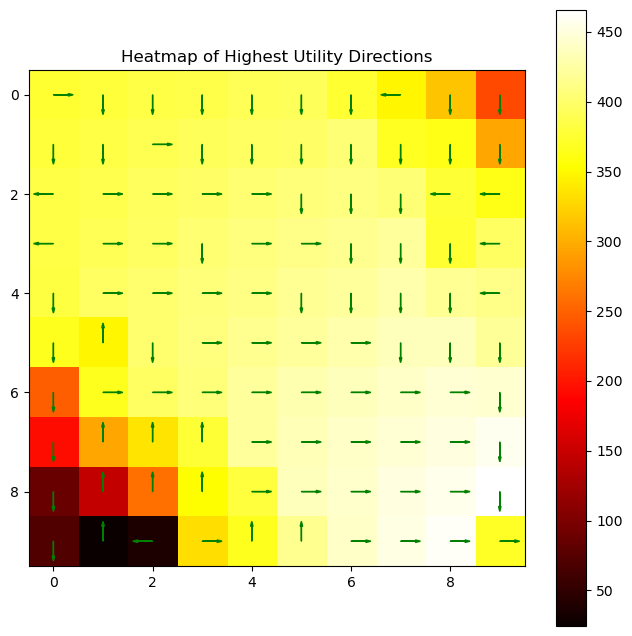

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.0001981496810913086, sd: 0.0001431352361587521
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


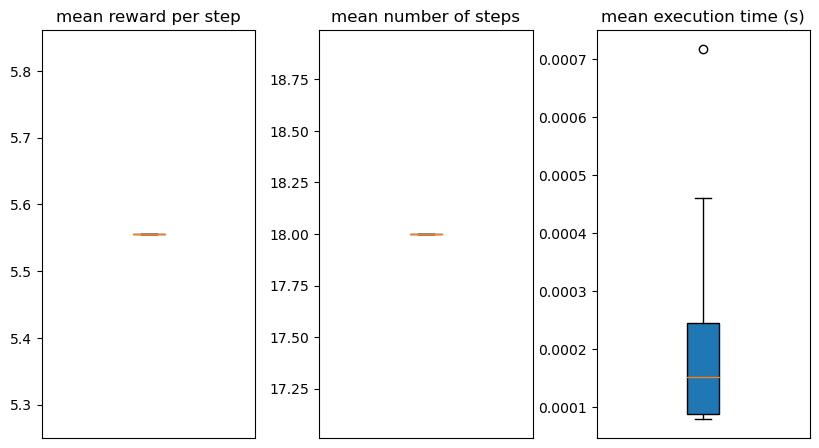

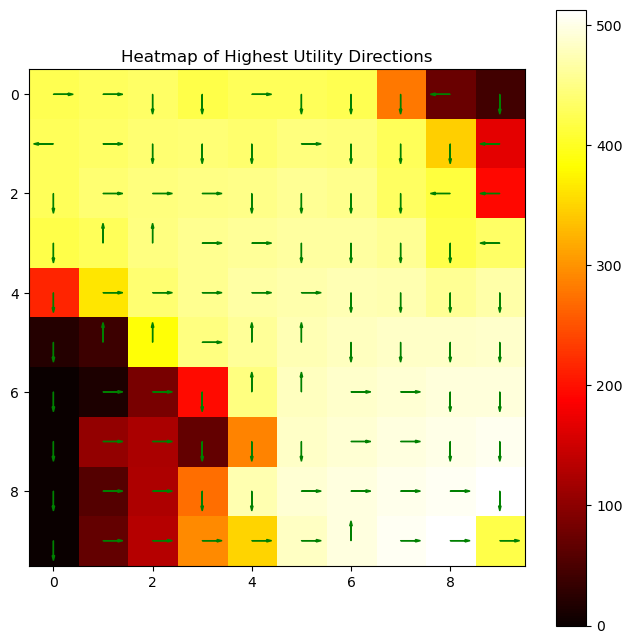

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.0001971721649169922, sd: 0.00015121872626751575
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


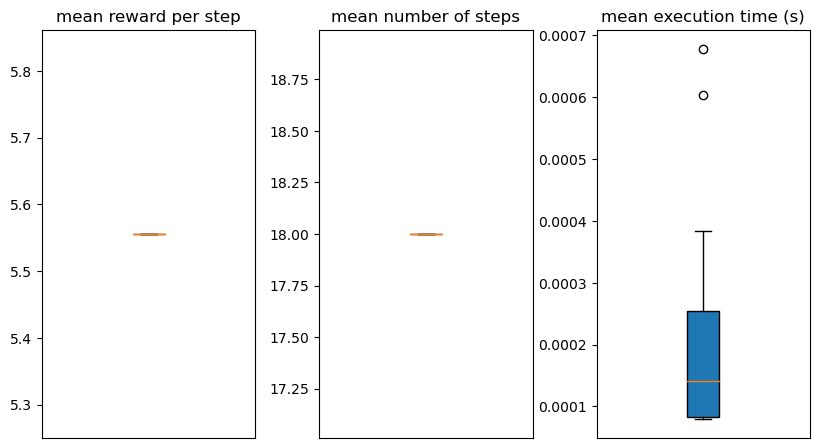

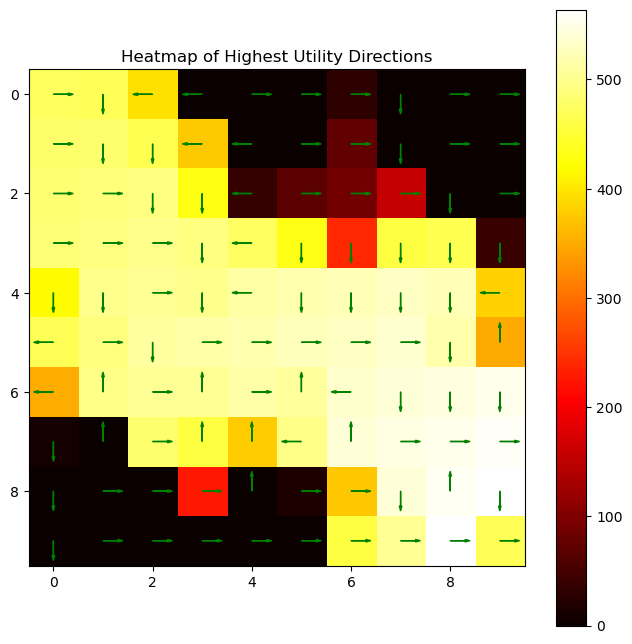

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00011782646179199218, sd: 5.3180470577988905e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


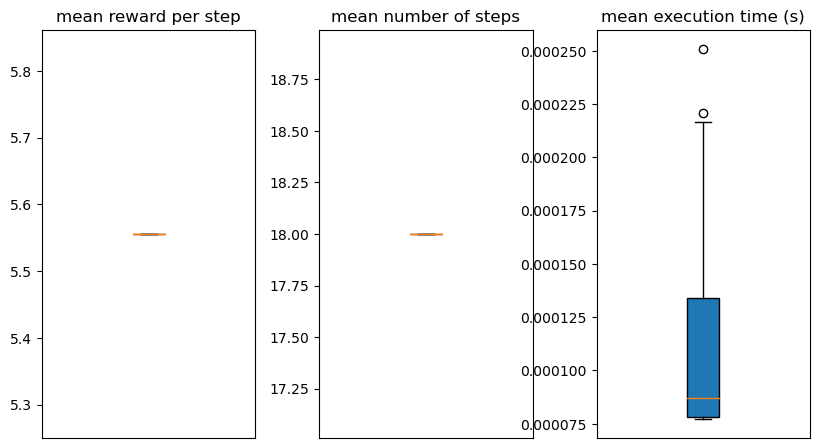

In [64]:
greedParameters = [0.3, 0.5, 0.8]

for percentage in greedParameters:
    allAverageRewardsPerStep, copyMatrixQ = runEpisodeWithUpdatingUtilitiesGreedy(greed = percentage, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000)
    showHeatmap(copyMatrixQ)
    testBaseline(copyMatrixQ, baseline = False, visualize = True)
    

Finally, try an increasing greed parameter starting at 30%, for the first 30% of the test steps, and slowly increasing until 100% by the end of the test. Compare test results and the Q tables.

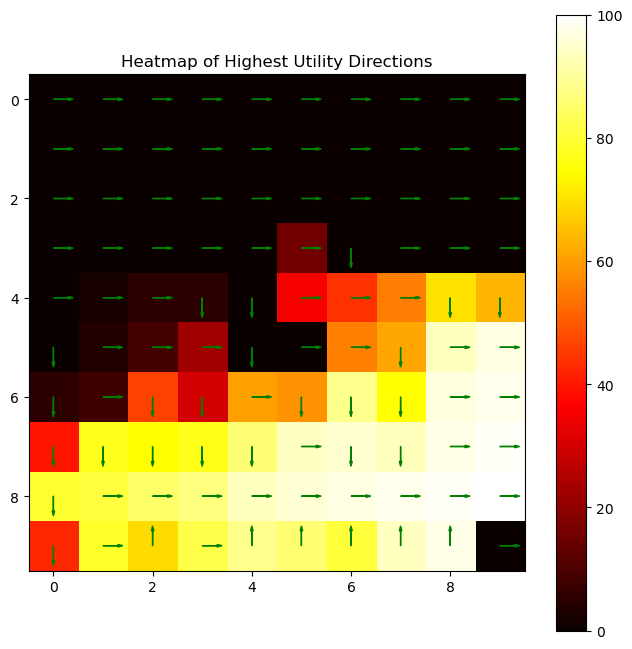

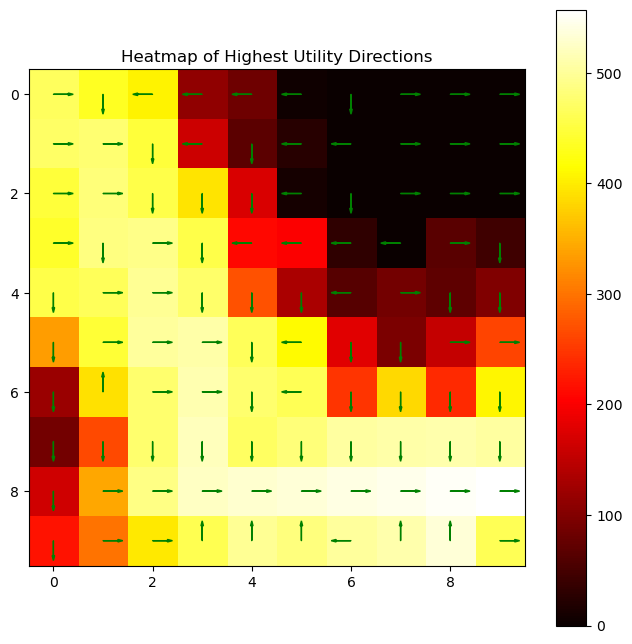

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00012771288553873697, sd: 5.2809664441828864e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


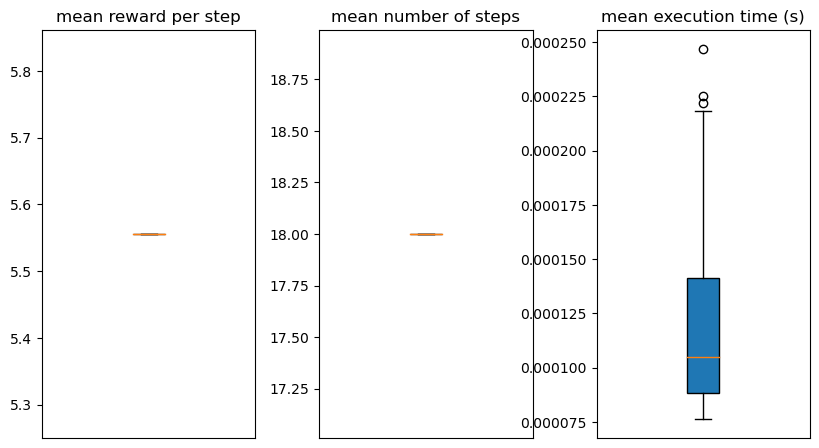

In [65]:
# increasing greed parameter

maxNumberSteps = 20000
firstThirtyPcRounds = maxNumberSteps*0.3
lastSeventyPcRoundsDividedBySeven = 2000
percentageStart = 0.3

#showHeatmap(matrixQEmpty)
allAverageRewardsPerStep, copyMatrixQFirstThirtyPcRounds = runEpisodeWithUpdatingUtilitiesGreedy(greed = percentageStart, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = int(firstThirtyPcRounds))
nextMatrixQToUse = copyMatrixQFirstThirtyPcRounds
showHeatmap(nextMatrixQToUse)

for i in range(1, 8):
    allAverageRewardsPerStep, MatrixQNow = runEpisodeWithUpdatingUtilitiesGreedy(greed = percentageStart + 0.1 * i, matrixQ = nextMatrixQToUse, state = 1, finalState = 100, maxNumberSteps = lastSeventyPcRoundsDividedBySeven)
    nextMatrixQToUse = MatrixQNow 
    #showHeatmap(nextMatrixQToUse)

finalMatrixQGreedy = nextMatrixQToUse
showHeatmap(finalMatrixQGreedy)
testBaseline(finalMatrixQGreedy, baseline = False, visualize = True)




### Exercise 4


Change the simulation to include walls and that bouncing off a wall gives a small penalty reward (-0.1). Compare with previous results.

In [67]:
wallOne = list(range(4, 90, 10))
wallTwo = list(range(17, 100, 10))


def stateTransitionFunctionWithWalls(state, action):
    penalty = 0
    newstate = state
    if newstate == 100:
        newstate = 1
    if action == 'right':
        newstate += 1
    elif action == 'left':
        newstate -= 1
    elif action == 'up':
        newstate -= 10
    elif action == 'down':
        newstate += 10
    
    if state == 100:
        state = newstate
    elif newstate in range(1, 101):
        if not (state % 10 == 1 and action == 'left') and not (state % 10 == 0 and action == 'right'):
            if newstate in wallOne or newstate in wallTwo:
                penalty += 0.1
            elif not newstate in wallOne and not newstate in wallTwo:
                state = newstate

    return state, penalty

In [68]:
def getUpdatedUtilityWalls(state, action, matrixQ, alpha, discountRate):
    QAtStateAndAction = matrixQ[action][state]
    nextState, penalty = stateTransitionFunctionWithWalls(state, action)
    rewardAtNextState = getReward(nextState) - penalty

    allPossibleUtilitiesAtNextState = [matrixQ["right"][nextState], matrixQ["left"][nextState], matrixQ["up"][nextState], matrixQ["down"][nextState]]
    random.shuffle(allPossibleUtilitiesAtNextState) # for ties, because max gives first value when tie
    maxUtilityNextState = max(allPossibleUtilitiesAtNextState)

    utilityState = (1-alpha)*QAtStateAndAction + alpha * (rewardAtNextState + discountRate*maxUtilityNextState)
    return (utilityState)

def updateUtilityWalls(state, action, matrixQ, alpha = 0.7, discountRate = 0.99):
    updatedUtility = getUpdatedUtilityWalls(state, action, matrixQ, alpha, discountRate)
    matrixQ[action][state] = updatedUtility

    return (matrixQ)

def runEpisodeWithUpdatingUtilitiesWithWalls(matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000, alwaysBestSep = False):
    copyMatrixQ = matrixQ.copy()
    listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
    count = 0
    allAverageRewardsPerStep = []
    
    for i in range(maxNumberSteps+1):
        if alwaysBestSep == True:
            action = getNextBestStep(state, copyMatrixQ)
        else:
            action = randomlyChoseAction()
        newState, penalty = stateTransitionFunctionWithWalls(state, action)
        copyMatrixQ = updateUtilityWalls(state = state, action = action, matrixQ = copyMatrixQ)
        state = newState
        if count in listWithPointsWhereTorRunTests:
            allAverageRewardsPerStep.append(runTest(state = state, matrixQ = copyMatrixQ, howManySteps = 1000))
        count += 1
        
    return (allAverageRewardsPerStep, copyMatrixQ)

execution time mean: 0.5484707037607829, sd: 0.06965379166853554


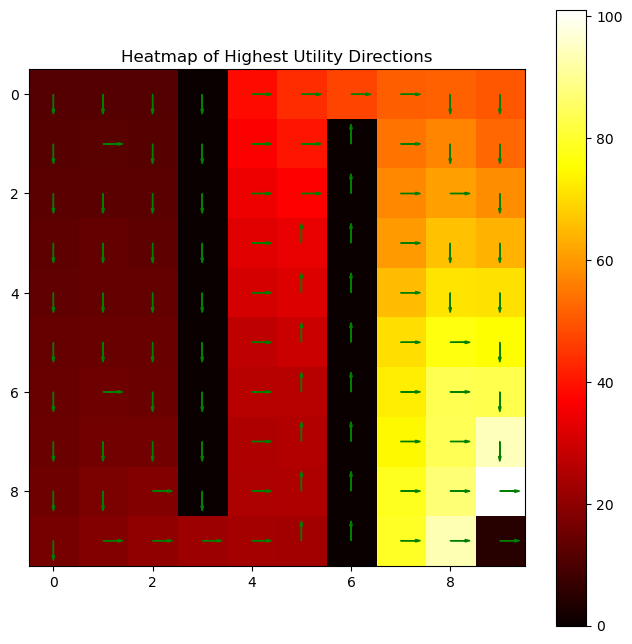

number of steps mean: 36.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00027015209197998045, sd: 0.0001355506999158945
average rewards per step: 2.777777777777777, sd: 1.3322676295501878e-15


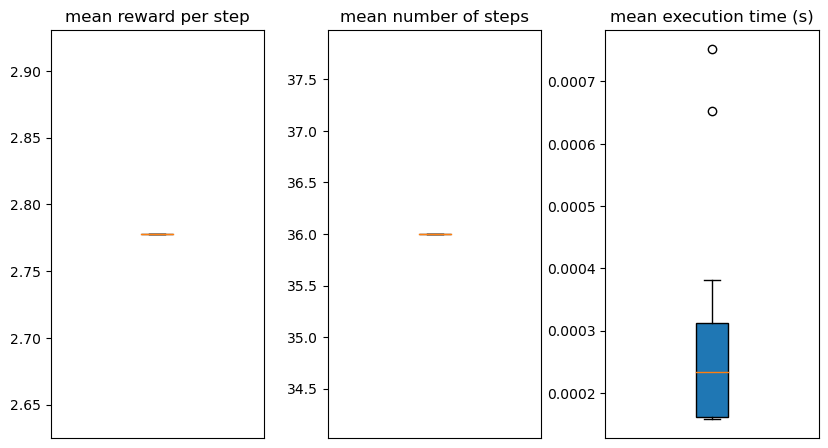

In [69]:
allexecutionTimes = []
allAllAverageRewardsPerStep = np.zeros((30, 16))
allMatrixQInList = []

random.seed(170)
for i in range(30):
    startTime = time.time()
    allAverageRewardsPerStep, MatrixQEndExplorationWalls = runEpisodeWithUpdatingUtilitiesWithWalls()
    endTime = time.time()
    executionTime = endTime - startTime

    allAllAverageRewardsPerStep[i] = allAverageRewardsPerStep

    allexecutionTimes.append(executionTime)
    allMatrixQInList.append(MatrixQEndExplorationWalls)



# execution time
meanExecutionTimesExploration = sum(allexecutionTimes) /len(allexecutionTimes)
sdExecutionTimes = np.std(allexecutionTimes)
print(f"execution time mean: {meanExecutionTimesExploration}, sd: {sdExecutionTimes}")


# average rewards per step for the 16 steps
averageRewardMeansWalls = np.mean(allAllAverageRewardsPerStep, axis=0)

# average utilities in matrices
averageMatrixQExplorationWalls = getAveragedMatrixQ(allMatrixQInList)

showHeatmap(averageMatrixQExplorationWalls)
testBaseline(averageMatrixQExplorationWalls, baseline = False, visualize = True)


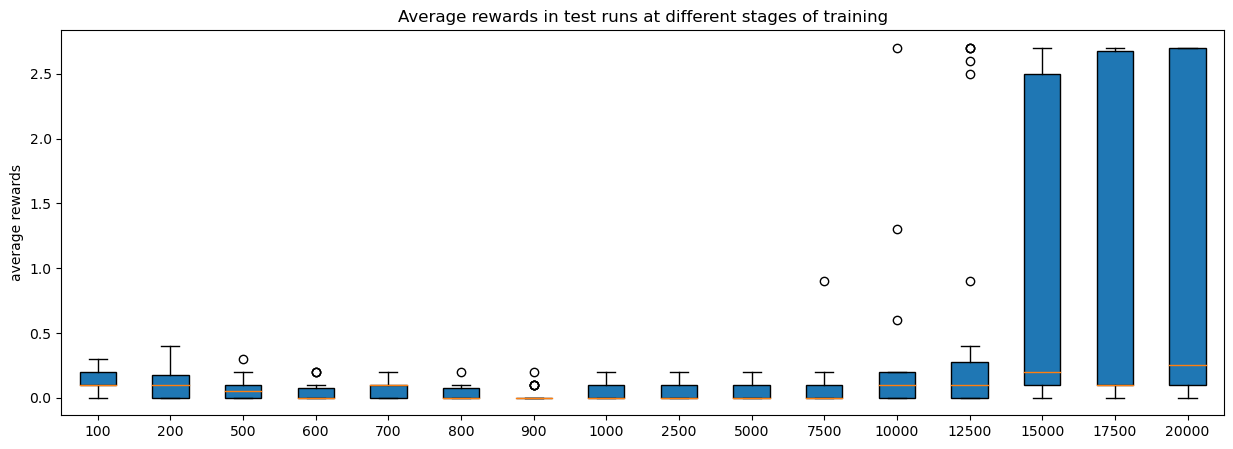

In [70]:
showBoxplot(values = allAllAverageRewardsPerStep, labels = listWithPointsWhereTorRunTests)

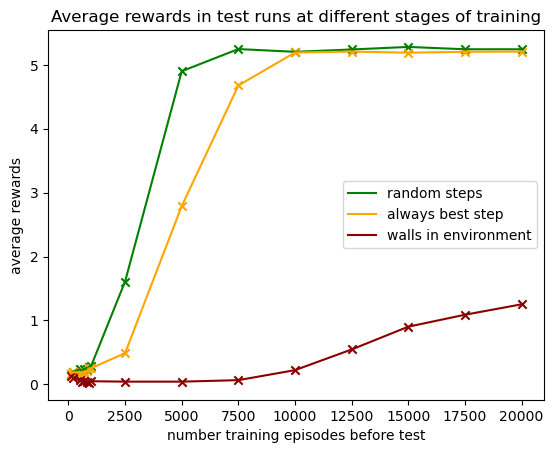

In [71]:
# visualize average reward 
listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c="green", label = "random steps")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansRandom,c='green', marker='x')

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", label = "always best step")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", marker='x')

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansWalls, c="darkred", label = "walls in environment")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansWalls, c="darkred", marker='x')

plt.title('Average rewards in test runs at different stages of training')
plt.xlabel("number training episodes before test")
plt.ylabel("average rewards")
plt.legend()
plt.show()

### Exercise 5 - optional

Imagine that the same action does not always take the robot to the same state (non- deterministic system). With a 5% probability it can take the robot to any neighbouring state of the current state. How does that affect the result?

In [72]:
def nonDeterministicTransition(state, action, probabilityForRandomAction = 0.05):
    randomFloat = random.random()
    if randomFloat > probabilityForRandomAction:
        state = stateTransitionFunction(state, action)
    else:
        randomAction = randomlyChoseAction()
        state = stateTransitionFunction(state, randomAction)
        
    return state

In [73]:
def runEpisodeWithUpdatingUtilitiesGreedyNonDeterministic(percentageExploitation, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000):
    copyMatrixQ = matrixQ.copy()
    listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
    count = 0
    allAverageRewardsPerStep = []
    for i in range(maxNumberSteps+1):
        action = chooseActionGreedy(state, copyMatrixQ, percentageExploitation)
        newState = nonDeterministicTransition(state, action, probabilityForRandomAction = 0.05)
        copyMatrixQ = updateUtility(state = state, action = action, matrixQ = copyMatrixQ)
        state = newState
        if count in listWithPointsWhereTorRunTests:
            allAverageRewardsPerStep.append(runTest(state = state, matrixQ = copyMatrixQ, howManySteps = 1000))
        count += 1
        
    return (allAverageRewardsPerStep, copyMatrixQ)

non deterministic:


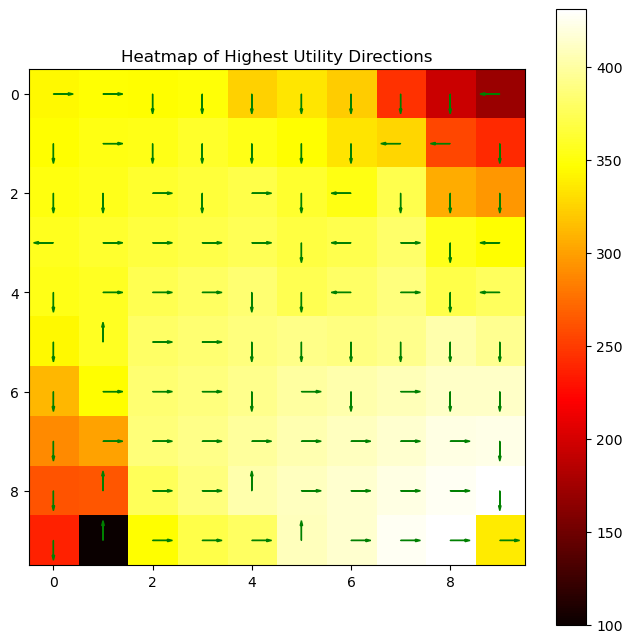

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00012939771016438802, sd: 5.4214376477435625e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


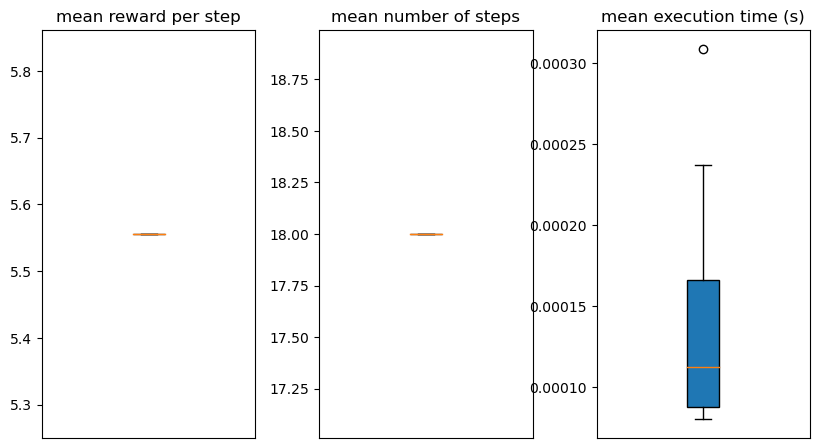

deterministic:


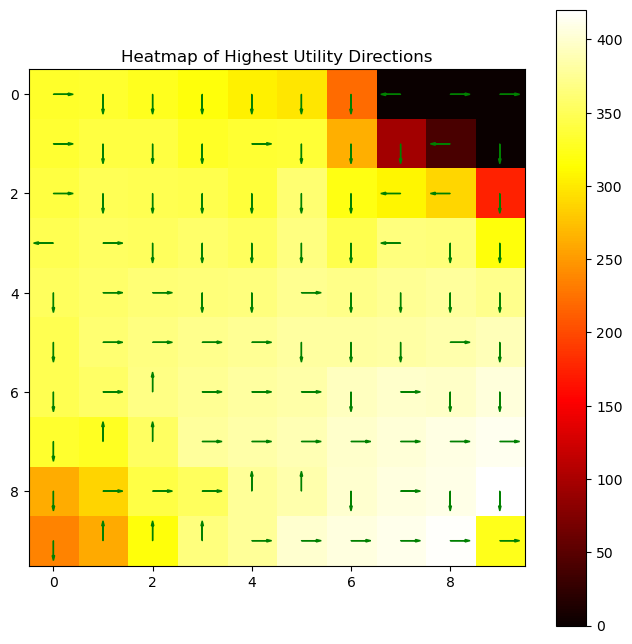

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00015445550282796225, sd: 0.00010669807392488003
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


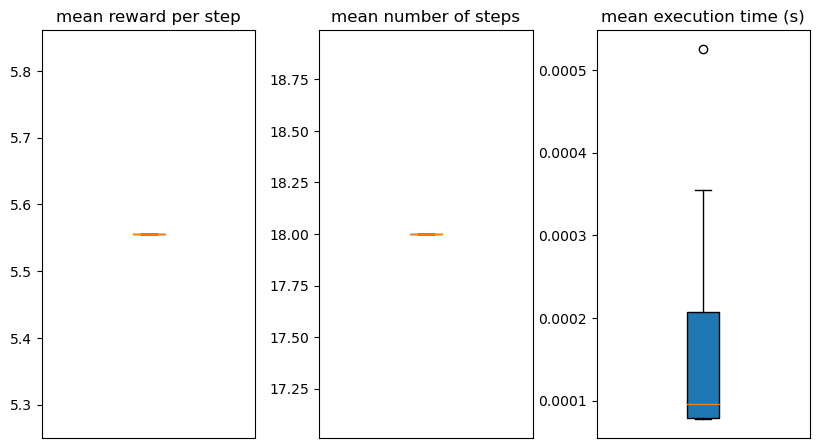

non deterministic:


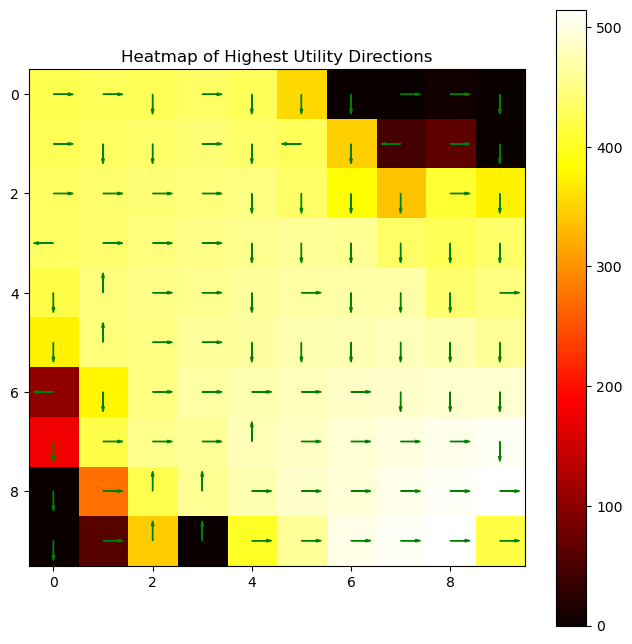

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.0001482725143432617, sd: 0.0001690990373526628
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


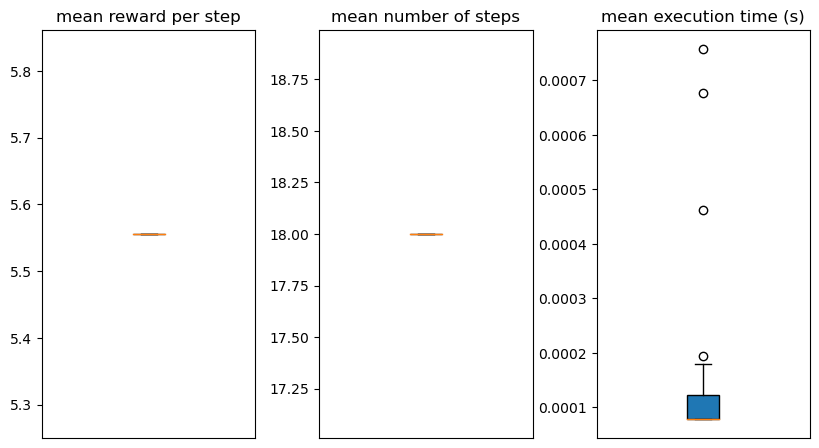

deterministic:


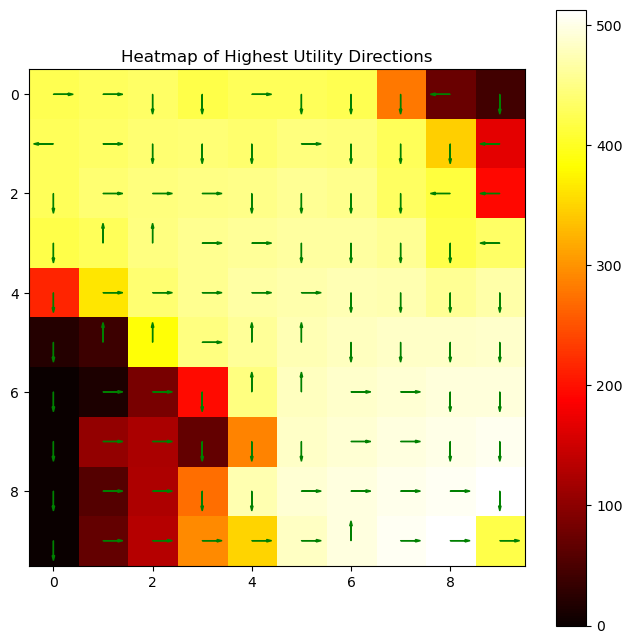

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00018090407053629557, sd: 0.00014276630710840252
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


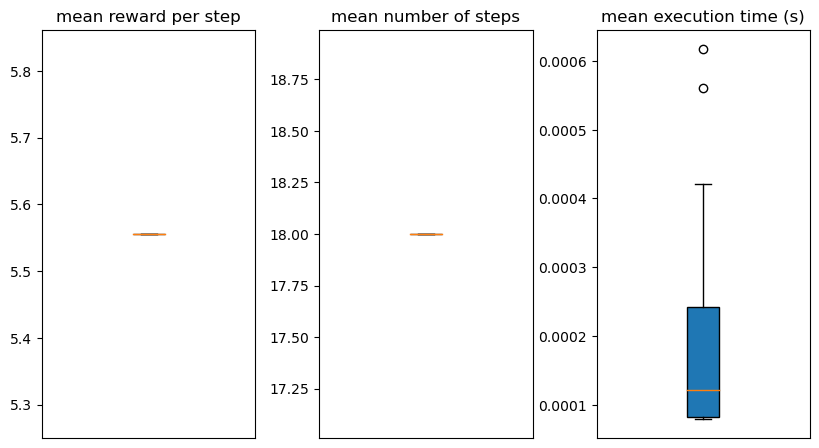

non deterministic:


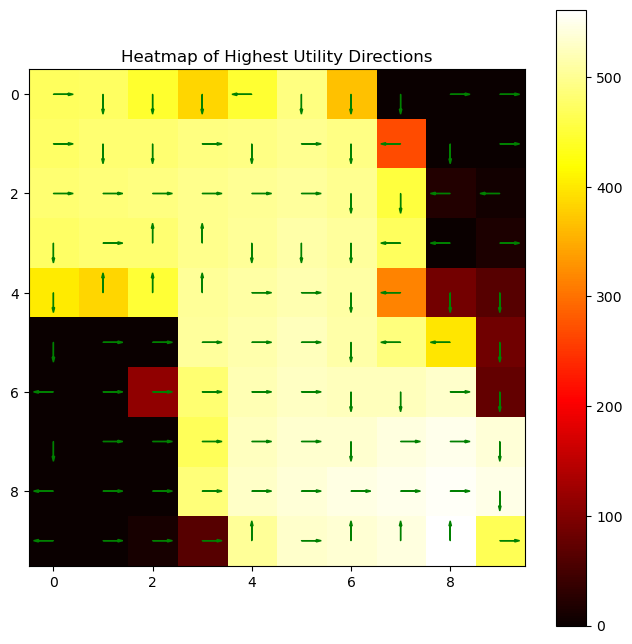

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00010916392008463542, sd: 8.040228956988411e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


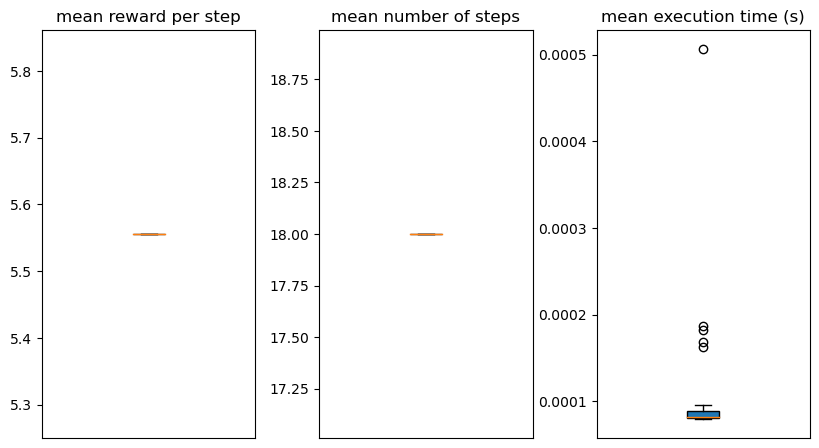

deterministic:


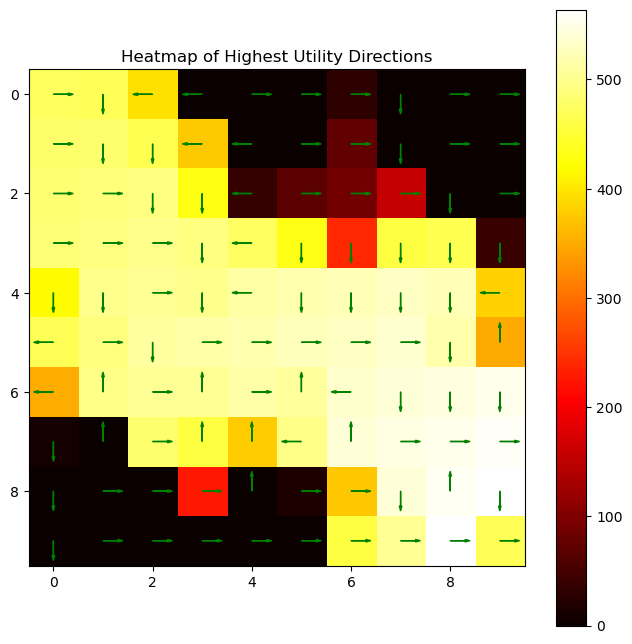

number of steps mean: 18.0, sd: 0.0
overall reward mean: 100.0, sd: 0.0
execution time mean: 0.00011962254842122396, sd: 6.479557109174696e-05
average rewards per step: 5.555555555555554, sd: 2.6645352591003757e-15


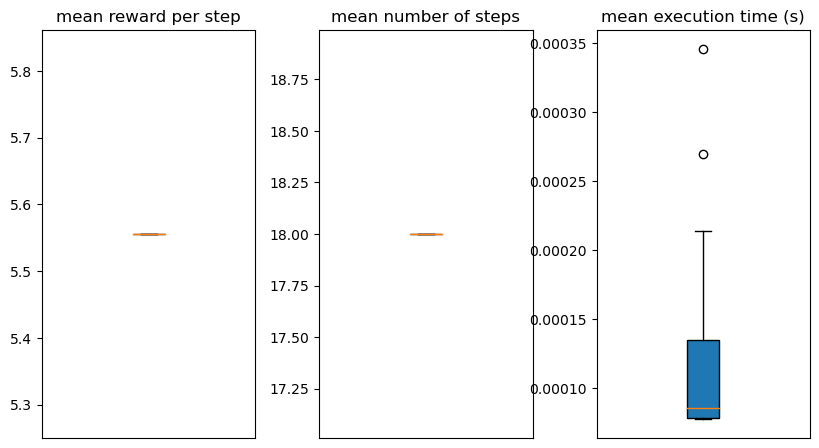

In [74]:
greedParameters = [0.3, 0.5, 0.8]

for percentage in greedParameters:
    allAverageRewardsPerStep, copyMatrixQND = runEpisodeWithUpdatingUtilitiesGreedyNonDeterministic(percentageExploitation = percentage, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000)
    print("non deterministic:")
    showHeatmap(copyMatrixQND)
    testBaseline(copyMatrixQND, baseline = False, visualize = True)

    allAverageRewardsPerStep, copyMatrixQ = runEpisodeWithUpdatingUtilitiesGreedy(greed = percentage, matrixQ = matrixQEmpty, state = 1, finalState = 100, maxNumberSteps = 20000)
    print("deterministic:")
    showHeatmap(copyMatrixQ)
    testBaseline(copyMatrixQ, baseline = False, visualize = True)


Non-deterministic leads to more randomness, meaning more exploration than greedyness parameter would suggest.